In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

## Generate and download HSC cutout images

* For most scientific applications, the coadd image will be the most useful one. And HSC archive provides ways to generate and download cutout coadd images around a desired location.  The best-fit PSF model at that location can be downloaded too.  

* Please see this [manual](https://hsc-release.mtk.nao.ac.jp/das_quarry/manual.html) for details about using the on-line cutout server; and see [here](https://hsc-release.mtk.nao.ac.jp/psf/pdr1/manual.html) for details about using the PSF Picker.

* Basic of HSC coadd images: 
    - Pixel scale: 0.168"/pix
    - Zeropoint: 27.0 mag in all 5-band
    - Maximum size of the cutout is 3 `Patches`, so about 35 arcmin.
    
### Step 1: Setup HSC-SSP online data archive 

* First, you need to setup a HSC-SSP rerun
* Here we use the ultra-deep field from the `PDR2` as an example

In [2]:
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_dud')

### Step 2: Design the cutout region

* There are two ways to design a cutout region:

1. Using the central coordinate and the size of the cutout region:
    * **Central coordinate** should be a `SkyCoord` object in `astropy`
    * **Size of the image** should be a `Quantity` object in `astropy`. It should have a **unit**, either angular or physical one is fine
        - For angular size: `u.arcsec` is default. 
        - For physical size: `u.kpc` is default, and you need to provide the `redshift` of the object. 
        - To convert physical size into pixel unit, we also need to assume cosmology. You can define cosmology model using the `cosmology` module in `astropy` and pass it to the code using `cosmo` option.  Default one assumes `H0=70.` and `Om=0.3` `LambdaCDMFlat` cosmology
2. Using the coordinates of the diagnoal corners.
    * Both **corner coordinates** should be `SkyCoord` objects.

* **Filters** used to generate the picture. Default is `i`
    - Formal format like `HSC-G` also works. 
    - A list of filters also works, like `gri`, or `[HSG-G, HSC-R]`.
    
* **Image type**:
    - `coadd`: Download the cutout of the coadd image. 
    - `warped`: Download the warped individual exposures that contribute to the cutout region. The output file is a `.tar` compressed file. 
    
* **Contents**:
    - `image`, `mask`, and `variance`.
    - "A FITS file cut out consists of 4 hdu's (header-data units, or layers): The primary hdu (0th hdu) does not contain any data. The 1st hdu is the image layer, the 2nd hdu is the mask layer, and the 3rd the variance layer."
    - Please note that "these hdu positions are immobile!"

In [3]:
coord_1 = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')
coord_2 = SkyCoord(150.1213, 2.235916, frame='icrs', unit='deg')

# Angular size
s_ang = 10.0 * u.arcsec

# Physical size
s_phy = 100.0 * u.kpc
redshift = 0.25

# Filters
filters = 'gri'

# Output dir
output_dir = 'data/'

#### For single-band, you can generate the URL of the cutout image using `form_cutout_url()` function

In [4]:
pdr2.form_cutout_url(coord_1, coord_2=coord_2)

'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr2/cgi-bin/cutout?ra1=150.091&dec1=2.20592&ra2=150.121&dec2=2.23592&type=coadd&image=on&mask=off&variance=off&filter=HSC-I&rerun=pdr2_dud'

### Running the `hsc_cutout()` task

# Retrieving cutout image in filter: i


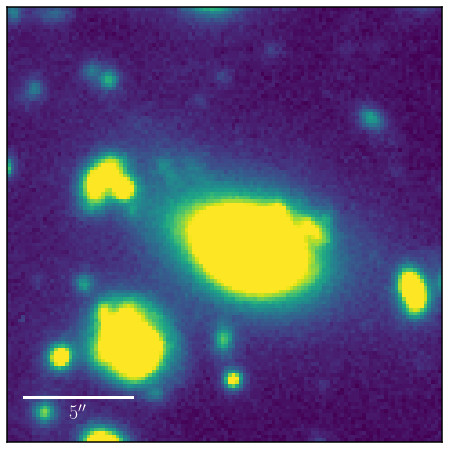

In [6]:
# Default 20"x20" cutout around a central coordinate in i-band, just get the image
coord_1 = SkyCoord(150.09134491441134, 2.2059167301972256, frame='icrs', unit='deg')
s_ang = 10.0 * u.arcsec

cutout_test = hsc_cutout(coord_1, cutout_size=s_ang, filters='i', archive=pdr2, 
                         use_saved=False, output_dir=output_dir, verbose=True, 
                         save_output=True)

_ = plotting.display_single(cutout_test[1].data)

cutout_test.close()

# Retrieving cutout image in filter: i


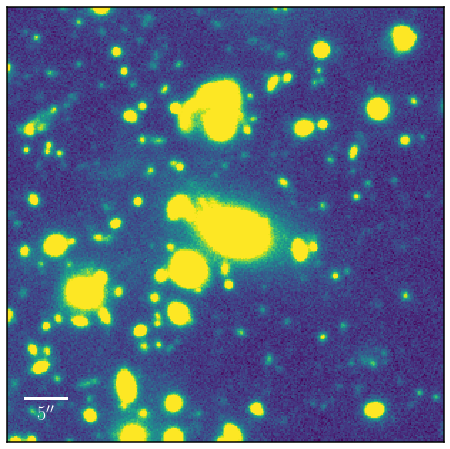

In [7]:
# Using the physical size
# Assuming z=0.25, and we want to get a 200x200 kpc cutout

cutout_phy = hsc_cutout(coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
                        archive=pdr2, use_saved=False, output_dir=output_dir, verbose=True, 
                        save_output=True)

_ = plotting.display_single(cutout_phy[1].data)

cutout_phy.close()

# Will dgenerate cutouts for a list of filters: ['g', 'i']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: i


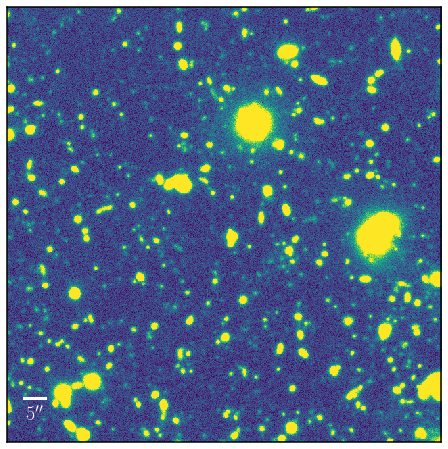

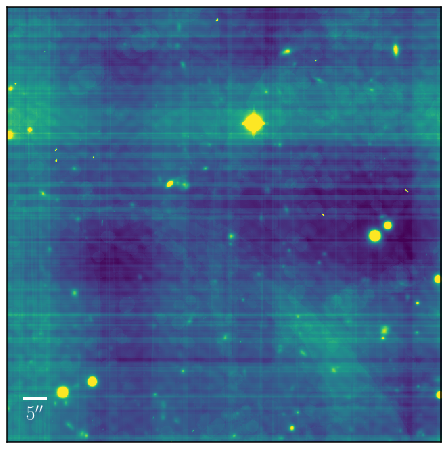

In [8]:
# Using the coordinates of two diagnoal corners
# Also get the mask and variance plane
# In both g- and i-band
# Save the FITS file with the prefix: "awesome_galaxy"

cutout_multi = hsc_cutout(coord_1, coord_2=coord_2, filters='gi', archive=pdr2, 
                          output_dir=output_dir, variance=True, mask=True, 
                          prefix='awesome_galaxy')

# g-band image
_ = plotting.display_single(cutout_multi[0][1].data)

# i-band variance plane
_ = plotting.display_single(cutout_multi[1][3].data)

In [42]:
# Download the tarball of the warped single exposure images in r-band

warped_url = hsc_cutout(coord_2, cutout_size=s_ang, filters='r', img_type='warp', 
                        archive=pdr2, use_saved=False, output_dir=output_dir)

# Retrieving warped images in filter: r
